# Model Evaluation & Hyperparameter Tuning
## Goal: Optimize models and evaluate their performance

### 📝 Tasks:
1. **Hyperparameter Tuning**: Improve model performance using GridSearchCV & Bayesian Optimization.
2. **Neural Network (MLP)**: Train and evaluate a simple Multi-Layer Perceptron (MLP).
3. **Model Evaluation**:
   - Confusion Matrix, ROC & Precision-Recall Curves
   - Feature Importance Analysis
   - Compare model performance metrics


### Load Required Libraries

In [5]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier


### Load Data & Models

In [ ]:

df = pd.read_csv("../data/raw_data.csv")


X = df.drop(columns=["Conversion"])  
y = df["Conversion"]
X = pd.get_dummies(X)
# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load trained models
models = {
    "RandomForest": joblib.load("../models/RandomForest.pkl"),
    "GradientBoost": joblib.load("../models/GradientBoost.pkl"),
    "XGBoost": joblib.load("../models/XGBoost.pkl"),
    "LightGBM": joblib.load("../models/LightGBM.pkl"),
    "CatBoost": joblib.load("../models/CatBoost.pkl"),
    "VotingClassifier": joblib.load("../models/VotingClassifier.pkl"),
    "StackingClassifier": joblib.load("../models/StackingClassifier.pkl"),
}


### Tuning the models 

In [ ]:

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
    },
    "GradientBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
    },
    "LightGBM": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "num_leaves": [31, 50],
    },
    "CatBoost": {
        "iterations": [100, 200],
        "learning_rate": [0.01, 0.1],
        "depth": [3, 6],
    }
}


models = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}


best_models = {}

for model_name, model in models.items():
    print(f"\n🔍 Tuning {model_name}...\n{'-'*40}")
    
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring="f1", n_jobs=-1, verbose=2)
    
    # Fit 
    grid_search.fit(X_train, y_train)
    
    # Save best model
    best_models[model_name] = grid_search.best_estimator_
    joblib.dump(grid_search.best_estimator_, f"../models/{model_name}_Tuned.pkl")
    
 
    print(f"✅ Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"🔹 Best F1 Score: {grid_search.best_score_:.4f}")




🔍 Tuning RandomForest...
----------------------------------------
Fitting 3 folds for each of 27 candidates, totalling 81 fits
✅ Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
🔹 Best F1 Score: 0.9414

🔍 Tuning GradientBoost...
----------------------------------------
Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ Best parameters for GradientBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
🔹 Best F1 Score: 0.9657

🔍 Tuning XGBoost...
----------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:03:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
🔹 Best F1 Score: 0.9624

🔍 Tuning LightGBM...
----------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5606, number of negative: 794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875938 -> initscore=1.954509
[LightGBM] [Info] Start training from score 1.954509
✅ Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}
🔹 Best F1 Score: 0.9588

🔍 Tuning CatBoost...
----------------------------------------
Fitting 3 fol

### Voting and Stacking classifiers with tuned models 

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib


models = {
    "RandomForest": joblib.load("../models/RandomForest_Tuned.pkl"),
    "GradientBoost": joblib.load("../models/GradientBoost_Tuned.pkl"),
    "XGBoost": joblib.load("../models/XGBoost_Tuned.pkl"),
    "LightGBM": joblib.load("../models/LightGBM_Tuned.pkl"),
    "CatBoost": joblib.load("../models/CatBoost_Tuned.pkl"),
}


model_performance = joblib.load("../models/model_performance.pkl")  


top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
print("\n🔹 **Top 3 Models based on F1 Score:**", top_3_models)

# Extract the model names
top_3_model_names = [model[0] for model in top_3_models]

# Get the actual classifiers for the top 3 models
top_3_classifiers = [(name, models[name]) for name in top_3_model_names]

### ✅ Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(estimators=top_3_classifiers, voting="hard")
voting_clf.fit(X_train, y_train)


joblib.dump(voting_clf, "../models/VotingClassifier_Tuned.pkl")

print("\n✅ Voting Classifier trained & saved!")

### ✅ Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=top_3_classifiers,
    final_estimator=LogisticRegression()  # Meta-learner
)
stacking_clf.fit(X_train, y_train)


joblib.dump(stacking_clf, "../models/StackingClassifier_Tuned.pkl")

print("\n✅ Stacking Classifier trained & saved!")



🔹 **Top 3 Models based on F1 Score:** [('CatBoost', (0.939375, 0.9657606777267914)), ('XGBoost', (0.930625, 0.9610115911485775)), ('LightGBM', (0.9275, 0.9593552908199019))]


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5606, number of negative: 794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875938 -> initscore=1.954509
[LightGBM] [Info] Start training from score 1.954509

✅ Voting Classifier trained & saved!


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5606, number of negative: 794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875938 -> initscore=1.954509
[LightGBM] [Info] Start training from score 1.954509


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features:

### Try MLP model 

In [32]:
mlp = MLPClassifier(hidden_layer_sizes=(4092, 512), activation="relu", solver="adam", max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Save
joblib.dump(mlp, "../models/MLP.pkl")


y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.03      0.06       194
           1       0.88      0.99      0.93      1406

    accuracy                           0.88      1600
   macro avg       0.64      0.51      0.50      1600
weighted avg       0.82      0.88      0.83      1600



Bad results compared to the other modelss 

### Confusion matrix reports 

🔹 RandomForest - Classification Report
              precision    recall  f1-score   support

           0       0.64      0.21      0.32       194
           1       0.90      0.98      0.94      1406

    accuracy                           0.89      1600
   macro avg       0.77      0.60      0.63      1600
weighted avg       0.87      0.89      0.86      1600



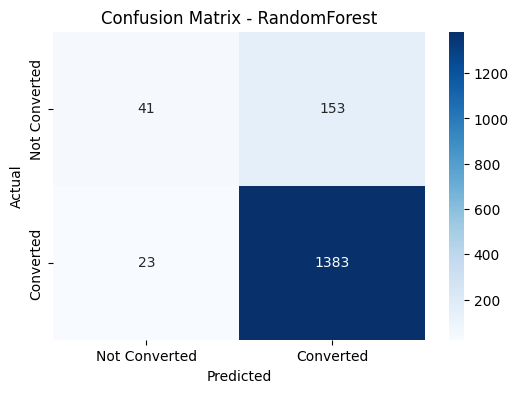

🔹 GradientBoost - Classification Report
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       194
           1       0.97      0.97      0.97      1406

    accuracy                           0.95      1600
   macro avg       0.88      0.87      0.88      1600
weighted avg       0.95      0.95      0.95      1600



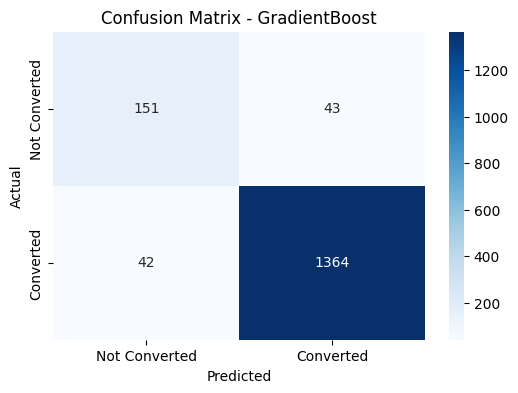

🔹 XGBoost - Classification Report
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       194
           1       0.96      0.97      0.96      1406

    accuracy                           0.94      1600
   macro avg       0.86      0.83      0.84      1600
weighted avg       0.93      0.94      0.93      1600



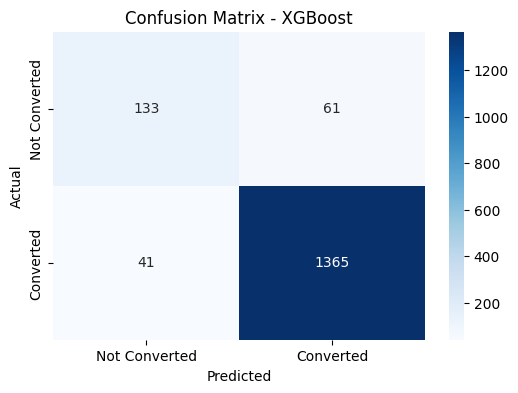

🔹 LightGBM - Classification Report
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       194
           1       0.95      0.97      0.96      1406

    accuracy                           0.93      1600
   macro avg       0.84      0.79      0.81      1600
weighted avg       0.92      0.93      0.92      1600



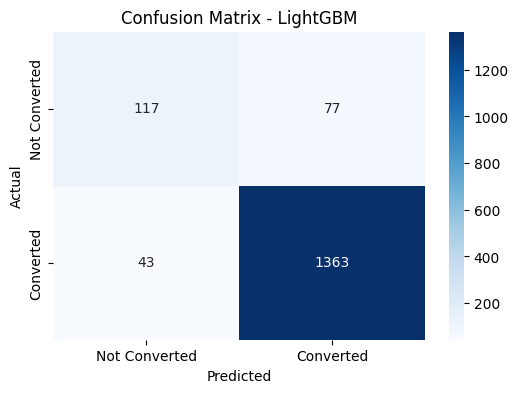

🔹 CatBoost - Classification Report
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       194
           1       0.95      0.97      0.96      1406

    accuracy                           0.93      1600
   macro avg       0.86      0.82      0.83      1600
weighted avg       0.93      0.93      0.93      1600



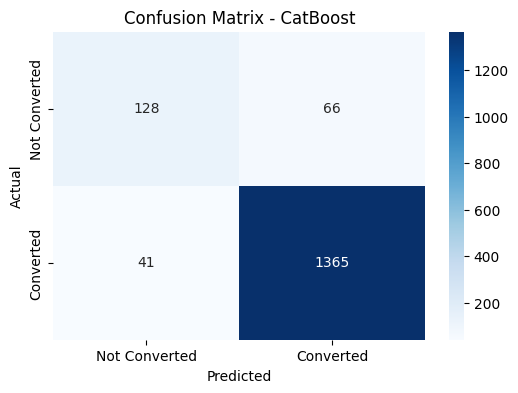

🔹 Stacking_classifier - Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       194
           1       0.97      0.97      0.97      1406

    accuracy                           0.94      1600
   macro avg       0.86      0.87      0.86      1600
weighted avg       0.94      0.94      0.94      1600



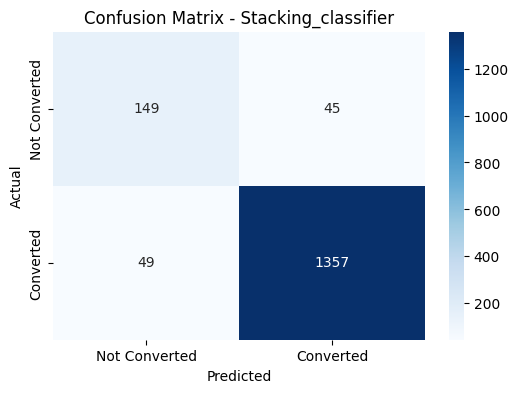

🔹 voting_classifier - Classification Report
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       194
           1       0.95      0.97      0.96      1406

    accuracy                           0.93      1600
   macro avg       0.85      0.81      0.83      1600
weighted avg       0.93      0.93      0.93      1600



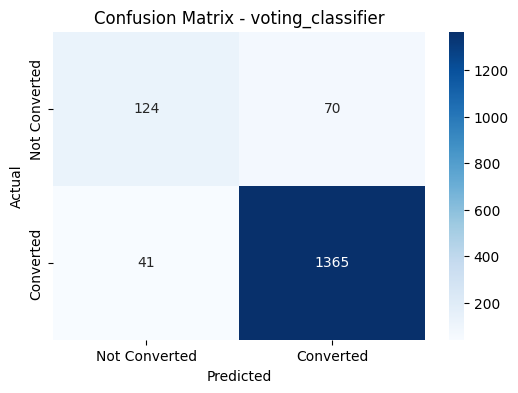

In [16]:

models = {
    "RandomForest": joblib.load("../models/RandomForest_Tuned.pkl"),
    "GradientBoost": joblib.load("../models/GradientBoost_Tuned.pkl"),
    "XGBoost": joblib.load("../models/XGBoost_Tuned.pkl"),
    "LightGBM": joblib.load("../models/LightGBM_Tuned.pkl"),
    "CatBoost": joblib.load("../models/CatBoost_Tuned.pkl"),
    "Stacking_classifier": joblib.load("../models/StackingClassifier_Tuned.pkl"),
    "voting_classifier": joblib.load("../models/VotingClassifier_Tuned.pkl"),
}
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Converted", "Converted"], yticklabels=["Not Converted", "Converted"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"🔹 {name} - Classification Report")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, name)


### ROC and Precision-recall curves

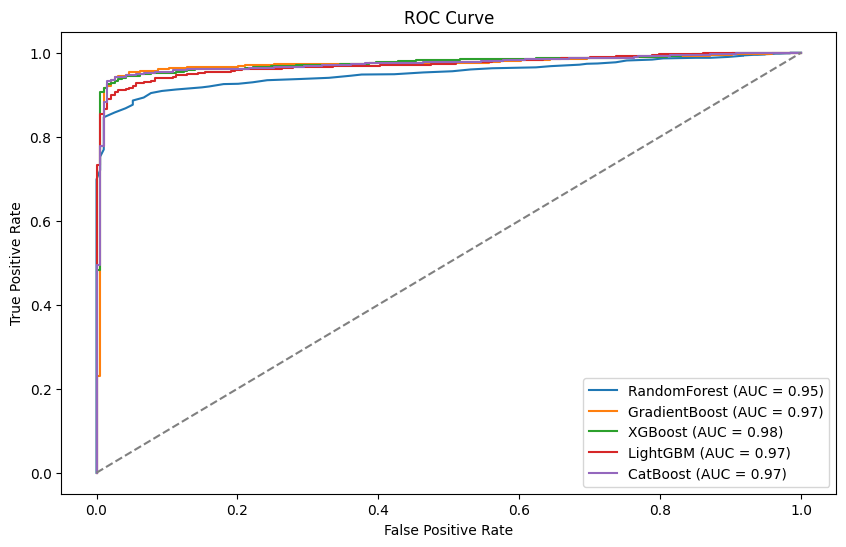

In [21]:
models = {
    "RandomForest": joblib.load("../models/RandomForest_Tuned.pkl"),
    "GradientBoost": joblib.load("../models/GradientBoost_Tuned.pkl"),
    "XGBoost": joblib.load("../models/XGBoost_Tuned.pkl"),
    "LightGBM": joblib.load("../models/LightGBM_Tuned.pkl"),
    "CatBoost": joblib.load("../models/CatBoost_Tuned.pkl"),
}

plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probability estimates
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


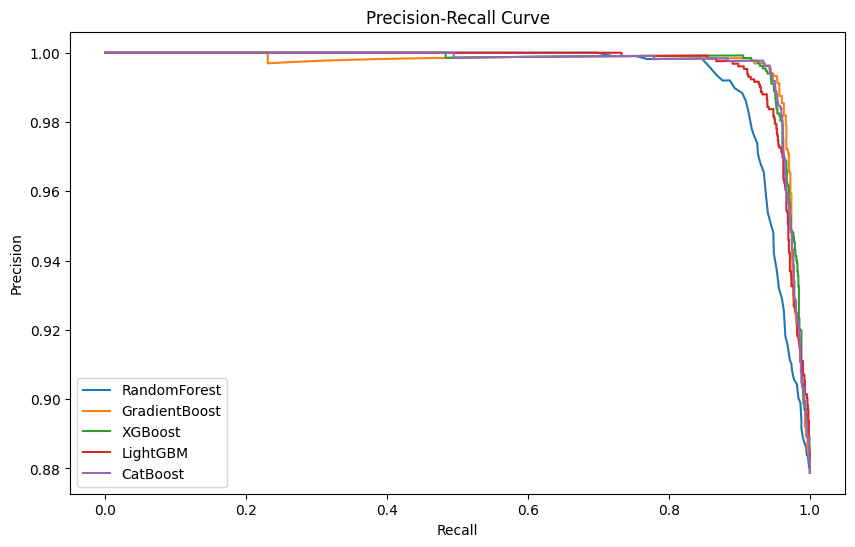

In [22]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


### Feature importance in each model 

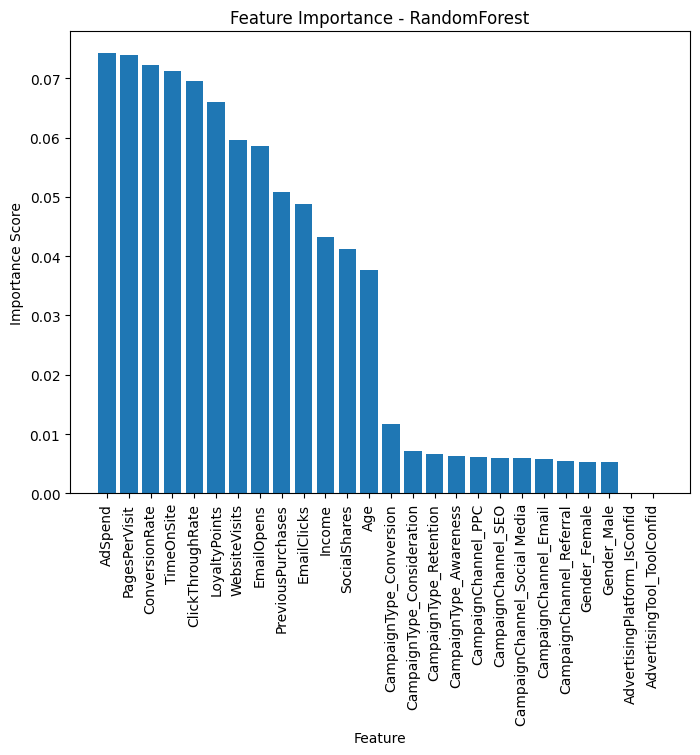

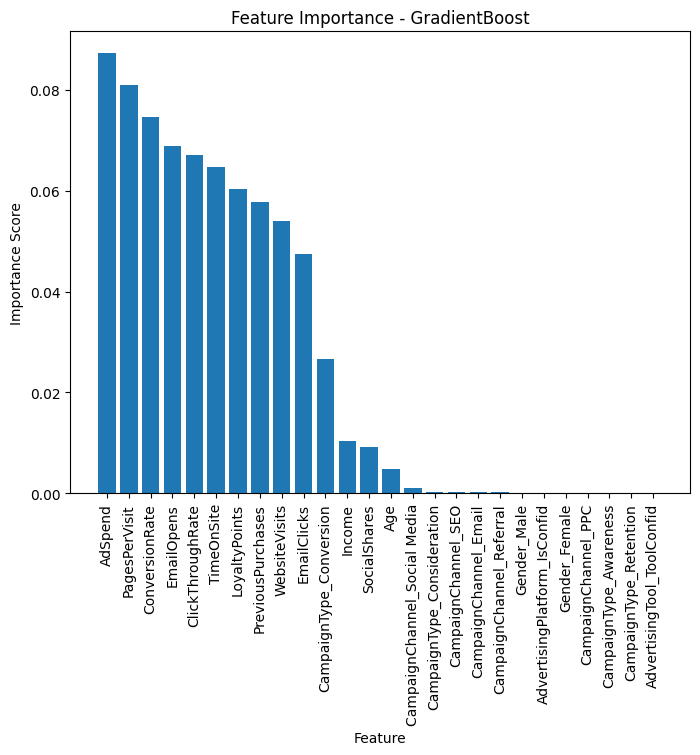

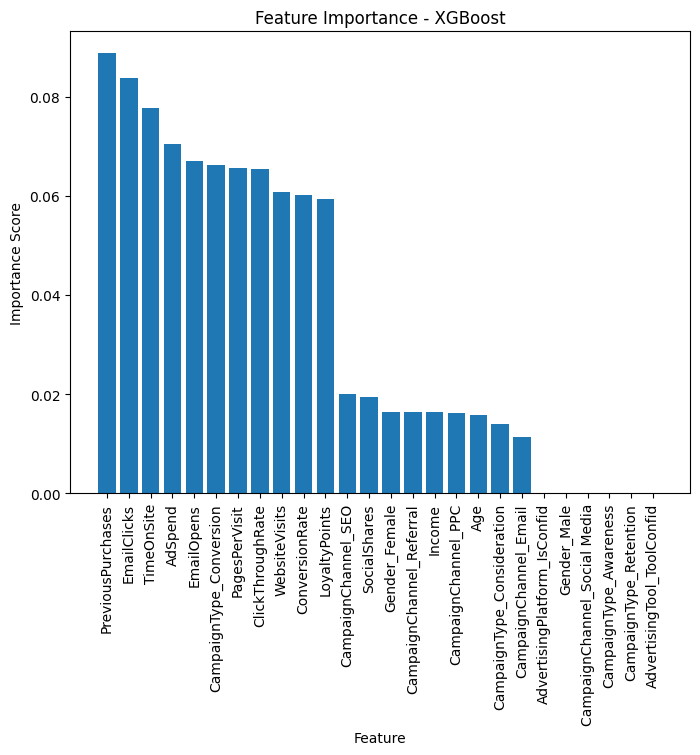

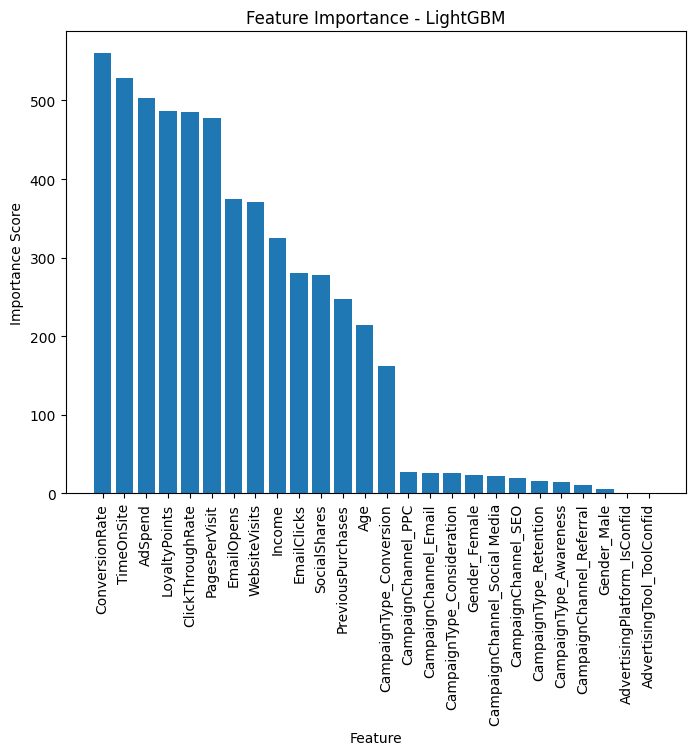

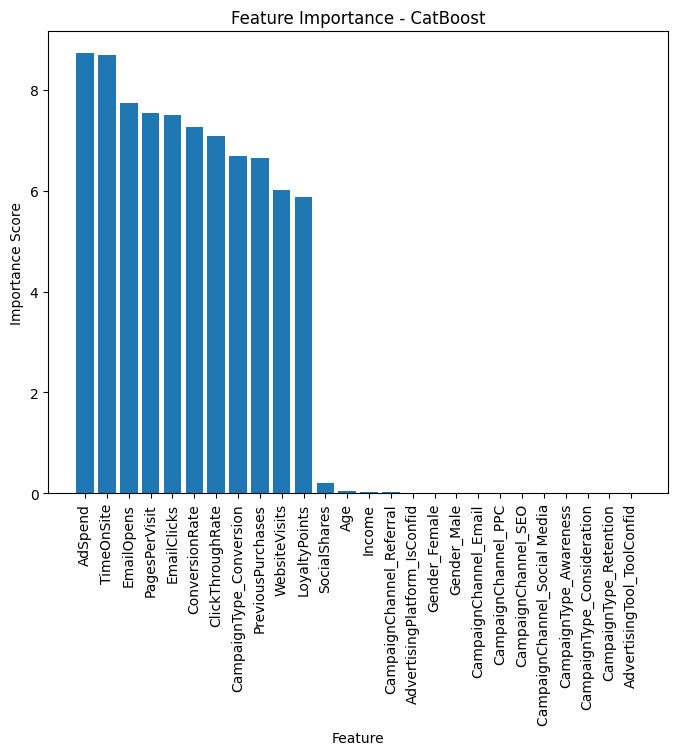

In [ ]:
def plot_feature_importance(model, model_name):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = np.array(X.columns)
        valid_mask = feature_names != "CustomerID"
        feature_names = feature_names[valid_mask]
        importances = importances[valid_mask]  # Apply same mask to importances
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 6))
        plt.title(f"Feature Importance - {model_name}")
        plt.bar(range(len(feature_names)), importances[indices], align="center")
        plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance Score")
        plt.show()

# Plot feature importance for tree-based models
for name, model in models.items():
    plot_feature_importance(model, name)


### Model benchmarking table 

In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd


scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']


model_results = []


for name, model in models.items():
    print(f"\n🔷 Evaluating {name} with Cross-Validation...")

    scores = {metric: cross_val_score(model, X_train, y_train, scoring=metric, cv=5).mean()
        for metric in scoring_metrics}

    scores['Model'] = name
    model_results.append(scores)


df_results = pd.DataFrame(model_results).set_index("Model")

# Sort by F1-score
df_results = df_results.sort_values(by="f1_weighted", ascending=False)

print("\n📊 **Model Benchmarking Table:**")
display(df_results)



🔷 Evaluating RandomForest with Cross-Validation...

🔷 Evaluating GradientBoost with Cross-Validation...

🔷 Evaluating XGBoost with Cross-Validation...


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:31:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:31:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:31:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 


🔷 Evaluating LightGBM with Cross-Validation...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points 

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875732 -> initscore=1.952623
[LightGBM] [Info] Start training from score 1.952623
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:32:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875732 -> initscore=1.952623
[LightGBM] [Info] Start training from score 1.952623
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:33:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875732 -> initscore=1.952623
[LightGBM] [Info] Start training from score 1.952623
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:34:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875732 -> initscore=1.952623
[LightGBM] [Info] Start training from score 1.952623
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3587, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3588, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features:

c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:35:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4484, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875781 -> initscore=1.953072
[LightGBM] [Info] Start training from score 1.953072


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869


c:\Users\oussama\Downloads\Marketing_Conversion_Analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4485, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5120, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875977 -> initscore=1.954869
[LightGBM] [Info] Start training from score 1.954869

📊 **Model Benchmarking Table:**


,accuracy,precision_weighted,recall_weighted,f1_weighted
Model,,,,
Stacking_classifier,0.941719,0.940650,0.941719,0.941071
GradientBoost,0.940938,0.938767,0.941094,0.939660
XGBoost,0.935469,0.932119,0.935469,0.932689
voting_classifier,0.934219,0.930326,0.934219,0.930696
CatBoost,0.934062,0.930115,0.934062,0.930683
LightGBM,0.924063,0.918272,0.924063,0.918908
RandomForest,0.888125,0.871515,0.887344,0.859269
